# Extensiones para Python con ctypes

Apuntes básicos sobre como llamar a funciones codificadas en C, compiladas con gcc. También, se presentan comparaciones gráficas de los tiempos de ejecución de diversas funciones.

## Dependencias

In [1]:
import os
import ctypes
import numpy

## Serie de Fibonacci

In [2]:
%%file c_fib.c
long long int c_fib(int n) {
    long long int tmp, a = 0, b = 1;
    for (int i=0; i<n; i++) {
        tmp = a;
        a = a + b;
        b = tmp;
    }
    return a;
}

Writing c_fib.c


In [3]:
# para generar el object file
! gcc -c -Wall -Werror  -fpic  c_fib.c

# para crear la shared library
! gcc -shared  c_fib.o -o _c_fib.so

In [4]:
def ctypes_fib():
    # ruta de la shared library
    lib = ctypes.CDLL('./_c_fib.so')
    
    # tipo de los argumentos
    lib.c_fib.argtypes = [ctypes.c_int]
    
    # tipo de la salida
    lib.c_fib.restype  = ctypes.c_longlong
    
    # se devuelve la función configurada
    return lib.c_fib

In [5]:
# instancia de la funcion
cfib = ctypes_fib()

### Prueba de Fibonacci

In [6]:
# los primeros 50 elementos de la serie de Fibonacci son
list(map(cfib,range(50)))

[0,
 1,
 1,
 2,
 3,
 5,
 8,
 13,
 21,
 34,
 55,
 89,
 144,
 233,
 377,
 610,
 987,
 1597,
 2584,
 4181,
 6765,
 10946,
 17711,
 28657,
 46368,
 75025,
 121393,
 196418,
 317811,
 514229,
 832040,
 1346269,
 2178309,
 3524578,
 5702887,
 9227465,
 14930352,
 24157817,
 39088169,
 63245986,
 102334155,
 165580141,
 267914296,
 433494437,
 701408733,
 1134903170,
 1836311903,
 2971215073,
 4807526976,
 7778742049]

## Suma de floats escalares

In [7]:
%%file scalarFloatAdd.c
// funcion que suma dos floats
float scalarFloatAdd(float a, float b){
    return a + b;
}

Writing scalarFloatAdd.c


In [8]:
# para generar el object file
! gcc -c -Wall -Werror -fpic scalarFloatAdd.c

# para crear la shared library
! gcc -shared scalarFloatAdd.o -o _scalarFloatAdd.so

In [9]:
def ctypes_scalar_float_add():
    # indicar la ruta de la shared library
    libfile = os.path.abspath(os.path.join(os.getcwd(),'_scalarFloatAdd.so'))

    # cargar la shared library
    lib = ctypes.CDLL(libfile)

    # tipo de dato de los argumentos
    lib.scalarFloatAdd.argtypes = [ctypes.c_float, ctypes.c_float]

    # tipo de dato del resultado
    lib.scalarFloatAdd.restype = ctypes.c_float
    
    # funcion configurada
    return lib.scalarFloatAdd

In [10]:
csfadd = ctypes_scalar_float_add()

### Prueba de la suma de floats escalares

In [11]:
# entradas
x = numpy.random.rand(10,1).astype(numpy.float32)
y = numpy.random.rand(10,1).astype(numpy.float32)

# salida de la libreria
zl = numpy.zeros((10,1),dtype=numpy.float32)

# salida de numpy
zn = numpy.zeros((10,1),dtype=numpy.float32)

# tam
size = len(x)

# usando la funcion de la libreria
for i in range(0,size):
    zl[i] = csfadd(x[i],y[i])
    
# usando bucles for 
for i in range(0,size):
    zn[i] = x[i]+y[i]

#calculando error relativo
from numpy import linalg as LA

print('el error relativo de la función %s es %f'%(csfadd.__name__,LA.norm(zn - zl) / LA.norm(zn)))

el error relativo de la función scalarFloatAdd es 0.000000


## Suma de arreglos de floats

In [12]:
%%file vectorFloatAdd.c
// funcion que suma dos arrays de floats
void vectorFloatAdd(float* a, float* b, float* c, int size){
    for(int i = 0; i < size; i++){
        c[i] = a[i] + b[i];
    }
}

Writing vectorFloatAdd.c


In [13]:
# crear el object file
! gcc -c -Wall -Werror -fpic vectorFloatAdd.c

# crear la shared library
! gcc -shared vectorFloatAdd.o -o _vectorFloatAdd.so

In [14]:
def ctypes_vector_float_add():
    # indicar la ruta de la shared library
    libfile = os.path.abspath(os.path.join(os.getcwd(),'_vectorFloatAdd.so'))

    # cargar la shared library
    lib = ctypes.CDLL(libfile)

    # tipo de dato de los argumentos
    lib.vectorFloatAdd.argtypes = [
        numpy.ctypeslib.ndpointer(dtype=numpy.float32),
        numpy.ctypeslib.ndpointer(dtype=numpy.float32),
        numpy.ctypeslib.ndpointer(dtype=numpy.float32),
        ctypes.c_int
    ]
    
    # funcion configurada
    return lib.vectorFloatAdd

In [15]:
cvfadd = ctypes_vector_float_add()

### Prueba de la suma de arrays de floats

In [16]:
#entradas
x = numpy.random.rand(10,1).astype(numpy.float32)
y = numpy.random.rand(10,1).astype(numpy.float32)

#salida de la libreria
zl = numpy.zeros((10,1),dtype=numpy.float32)

#salida de numpy
zn = numpy.zeros((10,1))

# tam
size = len(x)

#usando la funcion de la libreria
cvfadd(x,y,zl,size)
    
# usando bucles for 
for i in range(0,size):
    zn[i] = x[i]+y[i]

#calculando error relativo
from numpy import linalg as LA

print('el error relativo de la función %s es %f'%(cvfadd.__name__, LA.norm(zn - zl) / LA.norm(zn)))

el error relativo de la función vectorFloatAdd es 0.000000


## Suma de arreglos de floats con SIMD

In [17]:
%%file vectorFloatAddAsmSimd.asm
    global vectorFloatAddAsmSimd
    section .text
vectorFloatAddAsmSimd:
    xorpd xmm0, xmm0
    xorpd xmm1, xmm1
    cmp rcx, 0
    je done
next:
    movaps xmm0, [rdi]
    movaps xmm1, [rsi]
    addps xmm0, xmm1
    movaps  [rdx], xmm0
    add rdi, 16
    add rsi, 16
    add rdx, 16
    sub rcx, 4
    jnz next
done:
    ret

Writing vectorFloatAddAsmSimd.asm


In [18]:
%%file vectorFloatAddAsmSimd.c
extern void vectorFloatAddAsmSimd(float *v, float *u, float *w, int size);

void vectorFloatAddAsmSimdC(float *v, float *u, float *w, int size){
    vectorFloatAddAsmSimd(v,u,w,size);
}

Writing vectorFloatAddAsmSimd.c


In [19]:
! nasm -f elf64 vectorFloatAddAsmSimd.asm -o vectorFloatAddAsmSimd.o
! gcc -shared vectorFloatAddAsmSimd.o vectorFloatAddAsmSimd.c -o _vectorFloatAddAsmSimd.so

In [20]:
def ctypes_vector_float_add_asm_simd():
    # indicar la ruta de la shared library
    libfile = os.path.abspath(os.path.join(os.getcwd(),'_vectorFloatAddAsmSimd.so'))

    # cargar la shared library
    lib = ctypes.CDLL(libfile)

    # tipo de dato de los argumentos
    lib.vectorFloatAddAsmSimdC.argtypes = [
        numpy.ctypeslib.ndpointer(dtype=numpy.float32),
        numpy.ctypeslib.ndpointer(dtype=numpy.float32),
        numpy.ctypeslib.ndpointer(dtype=numpy.float32),
        ctypes.c_int
    ]
    
    # funcion configurada
    return lib.vectorFloatAddAsmSimdC

In [21]:
cvfaddas = ctypes_vector_float_add_asm_simd()

### Prueba de suma de arreglos de floats con SIMD

In [22]:
# tam
size = 1024

#entradas
x = numpy.random.rand(size,1).astype(numpy.float32)
y = numpy.random.rand(size,1).astype(numpy.float32)

#salida de la libreria
zl = numpy.zeros((size,1),dtype=numpy.float32)

#salida de numpy
zn = numpy.zeros((size,1))

#usando la funcion de la libreria
cvfaddas(x,y,zl,size)
    
# usando bucles for 
for i in range(0,size):
    zn[i] = x[i]+y[i]

#calculando error relativo
from numpy import linalg as LA

print('el error relativo de la función %s es %f'%(cvfaddas.__name__, LA.norm(zn - zl) / LA.norm(zn)))

el error relativo de la función vectorFloatAddAsmSimdC es 0.000000


## Comparación de tiempos de ejecución

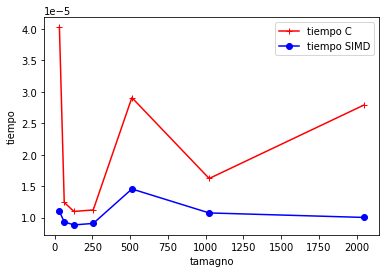

In [23]:
# modulo para graficar
import matplotlib.pyplot as plt

# modulo para medir el tiempo
import time

# tamagnos de los arreglos
sizes = 2**numpy.arange(5,12)

# tiempos de la suma de arreglos de floats
tc = numpy.zeros((len(sizes),1),dtype=numpy.float32)

# tiempos de la suma de arreglos de floats con SIMD
tasm = numpy.zeros((len(sizes),1),dtype=numpy.float32)

for i, size in enumerate(sizes):
    x = numpy.random.rand(size,1).astype(numpy.float32)
    y = numpy.random.rand(size,1).astype(numpy.float32)
    zl =  numpy.zeros((size,1),dtype=numpy.float32)
    zn =  numpy.zeros((size,1),dtype=numpy.float32)    
    t = time.time()
    cvfadd(x,y,zl,size)
    tc[i] = time.time() - t
    t = time.time()
    cvfaddas(x,y,zl,size)
    tasm[i] = time.time() - t

plt.plot(sizes, tc, 'r-+', label='tiempo C')
plt.plot(sizes, tasm, 'b-o', label='tiempo SIMD')
plt.xlabel('tamagno')
plt.ylabel('tiempo')
plt.legend()
plt.show()

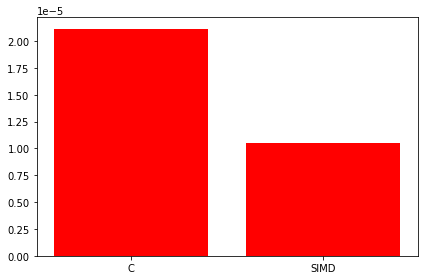

In [24]:
noms = ['C','SIMD']
proms = [ 
    numpy.mean(tc), 
    numpy.mean(tasm)
]
plt.bar(noms,proms,color='r')
plt.tight_layout()

In [25]:
print('el speedup es aprox %f'%(proms[0]/proms[1]))

el speedup es aprox 2.016234


In [26]:
! rm *.o
! rm *.so
! rm *.asm
! rm *.c